<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Reflexion_Agent_using_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Required Dependencies

In [1]:
%pip install -qU langchain langchain_openai langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 737.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.7 MB/s eta 0:00:00


#### Setup API key

In [2]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

#### Define classes

In [3]:
from typing import List
from pydantic import BaseModel,Field
#
class Reflection(BaseModel):
  print("----------REFLECTION------------------")
  missing: str = Field(description="Critique of what is missing.")
  superflous:str = Field(description="Critique of what is superflous")

#
class AnswerQuestion(BaseModel):
  print("----------ANSWER QUESTION------------------")
  answer:str = Field(description="`250 word detailed answer to the question.")
  reflection:Reflection = Field(description="Your Reflection on the initial answer.")
  search_queries:List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer.")

#
#forcing citations in the model encourages ground responses
class ReviseAnswer(AnswerQuestion):
  print("----------REVISE ANSWER------------------")
  referrences: List[str] = Field(description="Citations motivating your updated answer.")

----------REFLECTION------------------
----------ANSWER QUESTION------------------
----------REVISE ANSWER------------------


#### Instantiate LLM

In [4]:
from langchain_groq import ChatGroq
MODEL = "llama3-groq-70b-8192-tool-use-preview"
llm =ChatGroq(model_name=MODEL,temperature=0.0,max_tokens=3000)

#### Define Relexion Chains

In [ ]:
import datetime
from langchain_core.prompts import ChatPromptTemplate,HumanMessagePromptTemplate,MessagesPlaceholder
from langchain_core.output_parsers import PydanticToolsParser,JsonOutputToolsParser
#
actor_template = ChatPromptTemplate.from_messages([
    ("system","""You are an expert researcher.
    Current Time :{time}

    1. {first_instruction}
    2. Reflect and critique your answer.Be severe to maximize improvement.
    3. Recommend search queries to reserch information and improve your answer."""
    ),
    MessagesPlaceholder(variable_name="messages"),
    ("system","Answer the user's question above using the required format.")
]).partial(time=lambda:datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


In [ ]:
first_responder = actor_template.partial(
first_instruction="Provide a detailed ~250 word answer to the question."
) | llm.bind_tools(tools=[AnswerQuestion],tool_choice="AnswerQuestion")


#### Define Validator Tool

In [ ]:
validator = PydanticToolsParser(tools=[AnswerQuestion])

#### Reviser tool

In [ ]:
revise_instructions = """Revise your previous answer using the new information.
-You should use the previous critique to add important information to your answer.
- You MUST include numerical citations in your revised answer to ensure it can be verified.
- Add a 'Referrences' section to the bottom of your answer (Which does not count towards the word limit). In form of
  - [1] https://example.com
  - [2] https://example.com
- You should use the previous critique to remove superflous information from your answer and make SURE it is no more than 250 words.
"""
revisor = actor_template.partial(
first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer],tool_choice="ReviseAnswer")

#### Define the Tool

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode
#
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search,max_results=5)
#

In [ ]:
def run_queries(search_queries:List[str]):
  """Run the generated queries"""
  return tavily_tool.batch([{"query":query} for query in search_queries])

In [ ]:
tool_node = ToolNode(
    [StructuredTool.from_function(run_queries,name=AnswerQuestion.__name__),
     StructuredTool.from_function(run_queries,name=ReviseAnswer.__name__),
    ]
)

## Define Node

In [ ]:
from langgraph.graph import START,MessageGraph,StateGraph,END
#
max_iterations=3
builder = MessageGraph()
builder.add_node("draft",first_responder)
builder.add_node("execute_tool",tool_node)
builder.add_node("revise",revisor)
#
builder.add_edge("draft","execute_tool")
builder.add_edge("execute_tool","revise")
#

#### Define Event Loop

In [ ]:
from langchain_core.messages import BaseMessage,ToolMessage
from langchain_core.callbacks import CallbackManager
max_iterations =2
def event_loop(state:List[BaseMessage]):
  count_tool_visits = sum(isinstance(item,ToolMessage) for item in state)
  if count_tool_visits >= max_iterations:
    return END
  return "execute_tool"

In [ ]:
builder.add_conditional_edges("revise",event_loop)
builder.set_entry_point("draft")
graph = builder.compile()

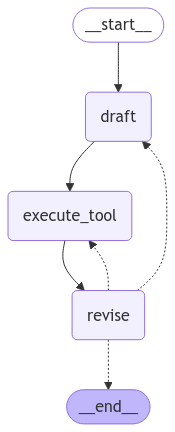

In [ ]:
from IPython.display import display,Markdown,Image
display(Image(graph.get_graph().draw_mermaid_png()))
#

In [ ]:
res = graph.invoke("Write about PydanticAI agent framework.")

In [ ]:
res[-1].tool_calls[0]

{'name': 'ReviseAnswer',
 'args': {'answer': 'The PydanticAI agent framework is a powerful tool for building complex AI applications, offering a structured way to define and manage AI agents, efficient communication, and task distribution. It simplifies the development process and ensures applications are scalable and efficient. The framework supports a variety of AI algorithms and can be easily integrated with existing systems, making it a versatile choice for both new and existing projects. For instance, it can be used to create customer service AI agents that assist human agents by automating repetitive tasks, suggesting responses, and streamlining workflows. Additionally, it can be applied in research and document analysis, such as reading unstructured documents, summarizing content, and mapping company names to tickers for investment analysis. Its applications are revolutionizing the way we build intelligent applications, enabling developers to create sophisticated AI systems that

In [ ]:
res[-1].tool_calls[0]['args']['answer']

'Multi-agent frameworks are a type of software that supports the development of multi-agent systems. These frameworks provide a set of tools, libraries, and services that enable the creation of complex systems where multiple agents can interact, collaborate, and adapt to their environment. They are designed to manage the complexity of developing and running multi-agent systems by providing abstractions, APIs, and runtime environments. Key features include agent management, communication protocols, task scheduling, and conflict resolution mechanisms. These frameworks are applied in various domains such as healthcare, transportation, and e-commerce, where distributed problem-solving and decision-making are crucial. They offer benefits like improved system scalability, flexibility, and fault tolerance. Researchers and practitioners use multi-agent frameworks to model and simulate complex scenarios, test algorithms, and validate system designs before deployment. The development of these fr

In [ ]:
res[0]

HumanMessage(content='Write about PydanticAI agent framework.', additional_kwargs={}, response_metadata={}, id='ab675083-e0d6-4d1e-b9ce-5893f2511281')

In [ ]:
res[1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wc24', 'function': {'arguments': '{"answer": "The PydanticAI agent framework is a powerful tool for building complex AI applications. It provides a structured way to define and manage AI agents, allowing for efficient communication and task distribution. With PydanticAI, developers can create a wide range of AI applications, from simple bots to complex multi-agent systems, all within a well-defined and maintainable framework. This not only simplifies the development process but also ensures that the resulting applications are scalable and efficient. Additionally, the framework supports a variety of AI algorithms and can be easily integrated with existing systems, making it a versatile choice for both new and existing projects.", "reflection": {"missing": "Could include specific use cases or examples of applications built with the framework to make the answer more concrete and practical.", "superflous": "The descriptio

#### Error

* BadRequestError: Error code: 400 - {'error': {'message': 'Please reduce the length of the messages or completion.', 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}



Hypothesis
The error message BadRequestError: Error code: 400 - {'error': {'message': 'Please reduce the length of the messages or completion.', 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}} indicates that the request sent to the Groq API is exceeding the maximum context length allowed by the model you are using (llama3-groq-70b-8192-tool-use-preview).

This is likely happening because:

Accumulation of Messages: The event_loop function allows the graph to iterate multiple times ("execute_tool" -> "revise"), and with each iteration, the message history grows. After a few iterations, the total length of messages and the new prompt might exceed the model's context window.
Long Input Prompt: The initial prompt "Write about Multi-Agentic Frameworks." might already be quite large, especially if previous interactions have added to the message history.
Model Limitations: The llama3-groq-70b-8192-tool-use-preview model has a context window limit. When the total length of the messages and the new prompt exceeds this limit, the API returns a 400 error.
Suggested Changes
To fix this issue, you can try the following:

Reduce the Number of Iterations: Reduce the max_iterations value in your event_loop function to limit the number of times the graph iterates and accumulates messages.

max_iterations = 1  # Reduced from 2 to 1
   def event_loop(state:List[BaseMessage]):
     count_tool_visits = sum(isinstance(item,ToolMessage) for item in state)
     if count_tool_visits >= max_iterations:
       return END
     return "execute_tool"
Use code with caution
Shorten the Input Prompt: Try providing a shorter, more specific initial prompt to reduce the initial context size. For example, instead of "Write about Multi-Agentic Frameworks.", you could try "Explain the key concepts of Multi-Agentic Frameworks."

Memory Management: Implement a memory management strategy to trim the conversation history. You could keep only the most recent or relevant messages, summarize previous exchanges, or use a sliding window to limit the history size. LangChain offers various memory implementations that can be integrated into your chain.

Increase max_tokens in llm instantiation: If possible, increase the max_tokens parameter when instantiating the ChatGroq object. However, be mindful of the model's context window limit.


llm = ChatGroq(model_name=MODEL, temperature=0.0, max_tokens=2000)  # Increased max_tokens
Use code with caution
By implementing these changes, you can reduce the likelihood of exceeding the context window limit and avoid the BadRequestError. Remember to experiment with different approaches to find the best solution for your specific use case.

Sources

## Method 2

In [343]:
from typing import List
from pydantic import BaseModel,Field
#
class AnswerQuestion(BaseModel):
  print("----------ANSWER QUESTION------------------")
  answer:str = Field(description="`250 word detailed answer to the question.Content should be in MARKDOWN Format")
  missing: str = Field(description="Critique of what is missing.")
  superflous:str = Field(description="Critique of what is superflous")
  search_queries:List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer.")

#
#forcing citations in the model encourages ground responses
class ReviseAnswer(BaseModel):
  print("----------REVISE ANSWER------------------")
  answer:str = Field(description="`250 word detailed answer to the question.")
  missing: str = Field(description="Critique of what is missing.")
  superflous:str = Field(description="Critique of what is superflous")
  search_queries:List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer.")
  referrences: List[str] = Field(description="List of Citations motivating your updated answer.")


----------ANSWER QUESTION------------------
----------REVISE ANSWER------------------


In [73]:
ReviseAnswer

__main__.ReviseAnswer

In [344]:
from typing import TypedDict,List
## State
class GraphState(TypedDict):
  missing: str
  superflous:str
  referrences : List[str]
  question : str
  answer : str
  search_queries:List[str]
  curent_time:str
  tool_iteration:int
  max_iterations : int


## Define Nodes

In [345]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser,JsonOutputParser
from langchain.output_parsers import OutputFixingParser

In [372]:
def first_responder(state:GraphState):
  print("----------------FIRST RESPONDER-------------------")
  question = state["question"]
  current_time = state["curent_time"]
  prompt_template = """You are an expert researcher.
    Current Time :{current_time}
    Question : {question}
    1. Provide a detailed ~250 word answer to the question.
    2. Reflect and critique your answer.Be severe to maximize improvement.
    3. Recommend search queries to reserch information and improve your answer.
   Answer the user's question above using the required format.
   Provide the Response in a JSON format with key variables as 'answer' , 'missing', 'superflous' and 'search_queries'"""

  prompt = PromptTemplate(template=prompt_template,input_variables=["question","current_time"])
  parser  = JsonOutputParser(pydantic_object=AnswerQuestion)
  responder_chain = prompt | llm | parser
  response =  responder_chain.invoke({"question":question,"current_time":current_time})
  print(response)
  try:
    pass
  except Exception as e:
    print(f"Error:{e}")
    new_parser = OutputFixingParser.from_llm(parser=parser,llm=llm)
    response = new_parser.parse(response)

  return {"question":question,"answer":response['answer'],"missing":response.get('missing',''),"superflous":response.get('superflous',''), "search_queries": response['search_queries']}

## External Tool

In [357]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode
#
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search,max_results=5)


In [348]:
r = tavily_tool.run("Write about PydanticAI agent framework.")

In [154]:
len(r)

5

In [155]:
r[0]

{'url': 'https://medium.com/ai-agent-insider/pydantic-ai-agent-framework-02b138e8db71',
 'content': 'Pydantic AI: Agent Framework. Pydantic AI: Agent Framework Pydantic AI: Agent Framework AI Agent Insider Pydantic AI is a Python framework that acts as a bridge between developers and LLMs, providing tools to create agents — entities that execute specific tasks based on system prompts, functions, and structured outputs. In Pydantic AI, an agent is a unit that combines the following components: Here’s a basic example of using Pydantic AI to create an agent that responds to user queries: from pydantic_ai import Agent, RunContext   from pydantic_ai import Agent Install Pydantic AI today and build your first agent! Pydantic Ai Agent Published in AI Agent Insider ----------------------------- AI Agent Insider AI Agent Insider See all from AI Agent Insider'}

In [358]:
def run_queries(state:GraphState):
  print("----------------TAVILY SEARCH RUN QUERIES-------------------")
  search_queries = state.get("search_queries",'')
  if search_queries == '':
    queries = [state['question']]
  else:
    queries = search_queries

  response = tavily_tool.batch([{"query":query} for query in search_queries])
  print(f"TAVILY Response :{response}")
  return {"referrences":response}
#

## Define Reviser Agent

In [374]:
def revise_answer(state:GraphState):
  print("----------------REVISER AGENT-------------------")
  revise_instructions = """Revise your previous answer using the new information.The revised answer should be meaningful and SHOULD INCLUDE Citations.
  PREVIOUS CRITIQUE INFORMATION
  Missing: {missing}
  Superflous: {superflous}

  NEW INFORMATION
  {referrences}

-You should use the previous critique to add important information to your answer.
- You MUST include numerical citations in your revised answer to ensure it can be verified.
- Add a 'Referrences' section to the bottom of your answer (Which does not count towards the word limit). In form of
  - [1] https://example.com
  - [2] https://example.com
- You should use the previous critique to remove superflous information from your answer and make SURE it is no more than 250 words.
- The content for the JSON key 'answer' should be in MARKDOWN Format,should include citations and should have a professional tone.
STRICTLY Provide the Response in a JSON format with key variables as 'answer','missing','superflous','search_queries and 'referrences'
"""
  prompt_template = PromptTemplate(template=revise_instructions,input_variables=["missing","superflous","referrences"])
  parser  = JsonOutputParser(pydantic_object=ReviseAnswer)
  inputs = {"missing":state["missing"],"superflous":state["superflous"],"referrences":state["referrences"]}

  urls = []
  revise_chain  = prompt_template | llm
  response = revise_chain.invoke(inputs)
  print(f"Revised Respponse:{response.content}")
  try:
    response = parser.parse(response.content)
  except Exception as e:
    print(f"Error:{e}")
    new_parser = OutputFixingParser.from_llm(parser=parser,llm=llm)
    response = new_parser.parse(response.content)
  print(f"Revised Respponse:{response.keys()}")
  custom_tool_iteration = state['tool_iteration'] + 1

  return {"question":state['question'],"answer":response['answer'],"missing":response.get('missing',''),"superflous":response.get('superflous',''), "search_queries": response.get('search_queries',""),"referrences":response.get('references',''),'tool_iteration':custom_tool_iteration}

## Decide to generate

In [369]:
def decide_to_generate(state:GraphState):
  print("----------------DECIDE TO GENERATE-------------------")
  print(f"States :{state}")
  count_tool_visits = state["tool_iteration"] + 1
  max_iteration = state["max_iterations"]
  if count_tool_visits >= max_iterations or state['search_queries'] == '':
    return END
  else:
    count_tool_visits += 1
    state["tool_iteration"] = count_tool_visits
    return "execute_tool"





## Add Nodes

In [375]:
from langgraph.graph import START,StateGraph,END
#
builder = StateGraph(GraphState)
builder.add_node("draft",first_responder)
builder.add_node("execute_tool",run_queries)
builder.add_node("revise",revise_answer)
#
builder.add_edge("draft","execute_tool")
builder.add_edge("execute_tool","revise")
#
builder.add_conditional_edges("revise",decide_to_generate)
builder.set_entry_point("draft")
graph = builder.compile()

## View Langgraph

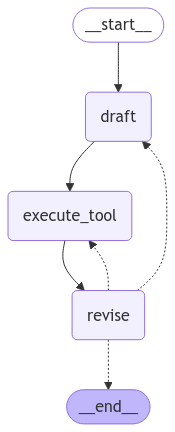

In [362]:
from IPython.display import display,Markdown,Image
display(Image(graph.get_graph().draw_mermaid_png()))
#

In [339]:
import datetime
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama3-8b-8192",temperature=0.0,max_tokens=3000)
query = "Write about PydanticAI agent framework."
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
inputs = {"question":query,"curent_time":current_time,"tool_iteration":0,"max_iterations":2}
res = graph.invoke(inputs)

----------------FIRST RESPONDER-------------------
{'answer': 'PydanticAI is an open-source, Python-based agent framework designed for building and deploying artificial intelligence (AI) and machine learning (ML) models. It provides a modular architecture that enables developers to create, train, and deploy AI agents that can interact with various environments, such as games, simulations, and real-world scenarios.\n\nPydanticAI is built on top of the Pydantic library, which provides a robust and flexible way to define and validate data models. The framework includes a range of features, such as support for reinforcement learning, imitation learning, and transfer learning, making it suitable for a wide range of AI applications.\n\nOne of the key benefits of PydanticAI is its ability to simplify the development and deployment of AI agents. It provides a high-level API that abstracts away many of the low-level details of AI development, allowing developers to focus on the logic and strate

In [340]:
res

{'missing': [],
 'superflous': [],
 'referrences': ['https://www.infoq.com/news/2024/12/pydanticai-framework-gen-ai/',
  'https://aipure.ai/products/pydantic-ai/introduction',
  'https://www.analyticsvidhya.com/blog/2024/12/pydanticai/',
  'https://medium.com/@samarrana407/pydantic-ai-the-python-agent-framework-to-build-production-grade-ai-agents-0ce322654fd7',
  'https://github.com/pydantic/pydantic-ai',
  'https://aipure.ai/products/pydantic-ai/features',
  'https://medium.com/ai-agent-insider/pydantic-ai-agent-framework-02b138e8db71'],
 'question': 'Write about PydanticAI agent framework.',
 'answer': "PydanticAI is a Python Agent Framework designed to streamline the development of production-grade AI applications by combining Pydantic's powerful data validation with LLM integration, offering type-safe dependency injection and model-agnostic support. It is an innovative agent framework developed by the team behind Pydantic, designed to simplify the process of building production-gra

In [341]:
print(res['answer'])

PydanticAI is a Python Agent Framework designed to streamline the development of production-grade AI applications by combining Pydantic's powerful data validation with LLM integration, offering type-safe dependency injection and model-agnostic support. It is an innovative agent framework developed by the team behind Pydantic, designed to simplify the process of building production-grade applications with Generative AI. PydanticAI is particularly useful for building complex AI applications that require reliable data handling and structured responses.

PydanticAI provides a range of features, including type safety, model-agnostic design, and seamless integration with large language models (LLMs). It also supports streamed responses and can validate structured responses using Pydantic models. Additionally, PydanticAI provides a focus on building robust applications with dynamic prompts, structured responses, and integration with observability tools like Logfire.

Overall, PydanticAI is a 

In [342]:
from IPython.display import display,Markdown,Image
display(Markdown(res['answer']+"\n\nReferences:\n\n"+"\n\n".join(res['referrences'])))

PydanticAI is a Python Agent Framework designed to streamline the development of production-grade AI applications by combining Pydantic's powerful data validation with LLM integration, offering type-safe dependency injection and model-agnostic support. It is an innovative agent framework developed by the team behind Pydantic, designed to simplify the process of building production-grade applications with Generative AI. PydanticAI is particularly useful for building complex AI applications that require reliable data handling and structured responses.

PydanticAI provides a range of features, including type safety, model-agnostic design, and seamless integration with large language models (LLMs). It also supports streamed responses and can validate structured responses using Pydantic models. Additionally, PydanticAI provides a focus on building robust applications with dynamic prompts, structured responses, and integration with observability tools like Logfire.

Overall, PydanticAI is a powerful tool for building production-grade AI applications, and its unique features make it an attractive option for developers looking to streamline their AI development process.

References:

https://www.infoq.com/news/2024/12/pydanticai-framework-gen-ai/

https://aipure.ai/products/pydantic-ai/introduction

https://www.analyticsvidhya.com/blog/2024/12/pydanticai/

https://medium.com/@samarrana407/pydantic-ai-the-python-agent-framework-to-build-production-grade-ai-agents-0ce322654fd7

https://github.com/pydantic/pydantic-ai

https://aipure.ai/products/pydantic-ai/features

https://medium.com/ai-agent-insider/pydantic-ai-agent-framework-02b138e8db71

In [381]:
import datetime
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama-3.3-70b-versatile",temperature=0.0,max_tokens=3000)
query = "What are the different types of Agentic Framework available."
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
inputs = {"question":query,"curent_time":current_time,"tool_iteration":0,"max_iterations":2}
res = graph.invoke(inputs)

----------------FIRST RESPONDER-------------------
{'answer': "The Agentic Framework refers to a conceptual structure that outlines the relationships between agents, their environment, and the actions they take. There are several types of Agentic Frameworks available, including: \n1. **Cognitive Architectures**: These frameworks focus on the mental processes and representations that underlie human cognition and behavior. Examples include SOAR, ACT-R, and CLARION. \n2. **Reinforcement Learning Frameworks**: These frameworks emphasize the role of reward and punishment in shaping an agent's behavior. Examples include Q-learning and SARSA. \n3. **Social Learning Frameworks**: These frameworks highlight the importance of social interactions and observations in shaping an agent's behavior. Examples include Social Cognitive Theory and the Theory of Planned Behavior. \n4. **Autonomous Agent Frameworks**: These frameworks focus on the design and development of autonomous systems that can percei

In [383]:
res

{'missing': 'The answer could be improved by providing more concrete examples and case studies to illustrate the application of each Agentic Framework.',
 'superflous': '',
 'referrences': ['[1] https://medium.com/@visrow/agentic-frameworks-what-why-who-when-where-and-how-874272b4812a',
  '[2] https://medium.com/@visrow/agentic-frameworks-what-why-who-when-where-and-how-874272b4812a',
  '[3] https://kodexolabs.com/what-is-agentic-ai/',
  '[4] https://kodexolabs.com/what-is-agentic-ai/',
  '[5] https://ieeexplore.ieee.org/document/10061750'],
 'question': 'What are the different types of Agentic Framework available.',
 'answer': 'Agentic frameworks enable AI-driven applications to take on tasks traditionally performed by humans, such as generating reports, automating workflows, or interacting with APIs [1]. By incorporating AI models, agentic frameworks can help in making data-driven decisions in real-time [2]. The concept of Agentic AI builds upon decades of research in artificial inte

In [384]:
from IPython.display import display,Markdown,Image
display(Markdown(res['answer']+"\n\nReferences:\n\n"+"\n\n".join(res['referrences'])))

Agentic frameworks enable AI-driven applications to take on tasks traditionally performed by humans, such as generating reports, automating workflows, or interacting with APIs [1]. By incorporating AI models, agentic frameworks can help in making data-driven decisions in real-time [2]. The concept of Agentic AI builds upon decades of research in artificial intelligence, machine learning, and autonomous systems [3]. Agentic frameworks have various applications, including autonomous vehicles, intelligent virtual assistants, and automated trading systems [4]. The development of agentic frameworks has been influenced by cognitive architectures, which provide a guide for applications in neuroscience, artificial intelligence, and robotics [5].

References:

[1] https://medium.com/@visrow/agentic-frameworks-what-why-who-when-where-and-how-874272b4812a

[2] https://medium.com/@visrow/agentic-frameworks-what-why-who-when-where-and-how-874272b4812a

[3] https://kodexolabs.com/what-is-agentic-ai/

[4] https://kodexolabs.com/what-is-agentic-ai/

[5] https://ieeexplore.ieee.org/document/10061750

In [385]:
import datetime
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama-3.3-70b-versatile",temperature=0.0,max_tokens=3000)
query = "What is Photosynthesis."
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
inputs = {"question":query,"curent_time":current_time,"tool_iteration":0,"max_iterations":2}
res = graph.invoke(inputs)

----------------FIRST RESPONDER-------------------
{'answer': 'Photosynthesis is the vital process by which plants, algae, and some bacteria convert light energy from the sun into chemical energy in the form of organic compounds, such as glucose. This complex process involves the conversion of carbon dioxide and water into glucose and oxygen, releasing energy that is stored in the chemical bonds of glucose. The overall equation for photosynthesis is 6CO2 + 6H2O + light energy → C6H12O6 (glucose) + 6O2. It occurs in specialized organelles called chloroplasts, which contain pigments such as chlorophyll that absorb light energy. The light-dependent reactions generate ATP and NADPH, which are then used in the light-independent reactions (Calvin cycle) to fix CO2 into glucose. Photosynthesis is essential for life on Earth, as it provides the primary source of energy for nearly all organisms, either directly or indirectly, and is responsible for the oxygen in the atmosphere.', 'missing': 'A 

In [387]:
res

{'missing': 'A detailed explanation of the light-dependent and light-independent reactions, as well as the importance of photosynthesis in the ecosystem and its impact on the environment. Additionally, the role of other pigments and the process of photorespiration could be explored.',
 'superflous': '',
 'referrences': ['[1] https://en.wikipedia.org/wiki/Light-dependent_reactions',
  '[2] https://www.biologyonline.com/dictionary/calvin-cycle',
  '[3] https://openstax.org/books/biology-ap-courses/pages/8-2-the-light-dependent-reaction-of-photosynthesis',
  '[4] https://www.thoughtco.com/what-is-the-calvin-cycle-608205',
  '[5] https://www.sciencing.com/what-are-the-roles-of-chlorophyll-a-b-12526386/',
  '[6] https://en.wikipedia.org/wiki/Photorespiration',
  '[7] https://www.britannica.com/question/Why-is-photosynthesis-important'],
 'question': 'What is Photosynthesis.',
 'answer': 'Photosynthesis is a crucial process that occurs in plants, algae, and some bacteria, where light energy 

In [386]:
from IPython.display import display,Markdown,Image
display(Markdown(res['answer']+"\n\nReferences:\n\n"+"\n\n".join(res['referrences'])))

Photosynthesis is a crucial process that occurs in plants, algae, and some bacteria, where light energy is converted into chemical energy [1]. The process involves two stages: the light-dependent reactions and the light-independent reactions (Calvin cycle) [2]. The light-dependent reactions occur in the thylakoid membranes and involve the conversion of light energy into ATP and NADPH [3]. The Calvin cycle, on the other hand, occurs in the stroma and involves the fixation of CO2 into glucose using the ATP and NADPH produced in the light-dependent reactions [4]. Other pigments, such as chlorophyll B, play a role in absorbing light energy and transferring it to chlorophyll A [5]. Photorespiration is a process that occurs in plants when the enzyme RuBisCO oxygenates RuBP, resulting in the loss of fixed carbon as CO2 [6]. The importance of photosynthesis cannot be overstated, as it provides energy and organic compounds for nearly all living organisms [7].

References:

[1] https://en.wikipedia.org/wiki/Light-dependent_reactions

[2] https://www.biologyonline.com/dictionary/calvin-cycle

[3] https://openstax.org/books/biology-ap-courses/pages/8-2-the-light-dependent-reaction-of-photosynthesis

[4] https://www.thoughtco.com/what-is-the-calvin-cycle-608205

[5] https://www.sciencing.com/what-are-the-roles-of-chlorophyll-a-b-12526386/

[6] https://en.wikipedia.org/wiki/Photorespiration

[7] https://www.britannica.com/question/Why-is-photosynthesis-important